In [1]:
# Copyright (c) 2023, ISCS, Wenjie Zhang.
#
# This source code is licensed under the MIT license found in the
# LICENSE file in the root directory of this source tree.

from __future__ import absolute_import, division, print_function, unicode_literals

import argparse

import builtins
import datetime
import json
import sys
import time

import numpy as np
import torch

from dsmeasure2.core.dsm_device_mng   import DeviceManager
from dsmeasure2.core.dsm_operator_mng import OperatorManager

from dsmeasure2.core.dsm_tensor   import AbstractTensor
from dsmeasure2.core.dsm_device   import AbstractDeviceConfig, AbstractDevice
from dsmeasure2.core.dsm_operator import AbstractOperatorConfig, \
                                         AbstractOperator, \
                                         OperatorComputationalConfig, \
                                         OperatorNonComputationalConfig , \
                                         OperatorCustomConfig , \
                                         OpStaticComputational , \
                                         OpStaticNonComputational, \
                                         OpStaticDerivative

from dsmeasure2.device.device_cuda import DeviceCUDA, DeviceCUDAConfig
from dsmeasure2.device.device_pcie import DevicePCIE4, DevicePCIEConfig

from dsmeasure2.core.dsm_tensor_mng    import TensorManager
from dsmeasure2.graph.tensor_define    import ActivationTensor, WeightTensor, TensorState
from dsmeasure2.graph.operator_graph   import UnaryOperator, BinaryOperator, TernaryOperator, InitiateOperator
from dsmeasure2.graph.unary_operator   import make_linear, make_layernorm, make_dropout, make_gelu, make_softmax
from dsmeasure2.graph.binary_operator  import make_add, make_matmul
from dsmeasure2.graph.operator_attn    import make_attn_tp, AttentionTPCRParallel, AttentionTPCRParallelBackward
from dsmeasure2.graph.dsm2_transformer import make_ffn_gpt2, FeedForwardGPT2, FeedForwardGPT2Backward, \
                                              make_transformer_block, TransformerBlockGPT2, TransformerBlockGPT2Backward
from dsmeasure2.graph.gpt2_sequence    import make_gpt_2
from dsmeasure2.engine import CostEngine

from dsmeasure2.flatten.flatten import flatten, convert_graph_to_flatten_seq
from dsmeasure2.flatten.flatten_engine import FlattenEngine
from dsmeasure2.flatten.flatten_stream import FlattenStream, stream_synchronize
from dsmeasure2.flatten.flatten_offload import make_passive_offload
from dsmeasure2.flatten.flatten_operator import FlattenInitiate, FlattenOperator

gpt2 = make_gpt_2(
        compute_time_linear_qkv=490,
        compute_time_matmul_kq=214, 
        compute_time_sm=163,
        compute_time_attention_dropout=286,
        compute_time_matmul_v=191,
        compute_time_linear=146,
        compute_time_dropout_attn=140,

        compute_time_linear_qkv_backward=340,
        compute_time_matmul_kq_backward=531,
        compute_time_sm_backward=212,
        compute_time_attention_dropout_backward=248,
        compute_time_matmul_v_backward=360,
        compute_time_linear_backward=250,
        compute_time_dropout_attn_backward=155,

        compute_time_allreduce_attn=2200,

        compute_time_linear_1=512,
        compute_time_gelu=428,
        compute_time_linear_2=483,
        compute_time_dropout_ffn=75,
        
        compute_time_linear_1_backward=442,
        compute_time_gelu_backward=210,
        compute_time_linear_2_backward=100,
        compute_time_dropout_ffn_backward=102,

        compute_time_allreduce_ffn=2200,
        
        compute_time_layernorm_1=67,
        compute_time_layernorm_2=67,
        compute_time_residual_add_1=67,
        compute_time_residual_add_2=67,

        compute_time_layernorm_1_backward=236,
        compute_time_layernorm_2_backward=236,

        compute_time_loss_with_backward=20000,

        batch_size=16,
        seq_len=1024,
        hidden_size=1792,
        head_num=16,
        head_hidden_size=112,
        tensor_parallel=2,
        precision=2,

        transfomer_block_num=32
    )
for _op in gpt2:
        OperatorManager().register(_op)
DeviceManager().register(DeviceCUDAConfig(memory_max_capacity=80000, memory_limit_capacity=80000))
DeviceManager().register(DevicePCIEConfig())
# CostEngine().evaluation(10, [_op._config.op_uid for _op in gpt2])
seq2 = flatten([_op._config.op_uid for _op in gpt2], [0], False)
seq2 = convert_graph_to_flatten_seq([_op._config.op_uid for _op in gpt2], [0])
stream_0 = FlattenStream(seq2)

In [2]:
FlattenEngine().evaluation([stream_0], 10)
a = FlattenEngine()._cuda_mem_trace.copy()
_ref_count = FlattenEngine()._tensor_ref_cnt.copy()
_interval_tot = FlattenEngine()._interval_tot

In [3]:
offload_streams = []
_i = 2
_end = int(len(stream_0._flat_seq) / 2) - 1
_tensor_seen = {}
while _i < _end:
    if isinstance(stream_0[_i], FlattenOperator) and 'backward' not in stream_0[_i]._config.op_name:
        _T = stream_0[_i]._input[0]
        if _T.tensor_uid not in _tensor_seen:
            _tensor_seen[_T.tensor_uid] = 0
        else:
            _tensor_seen[_T.tensor_uid] += 1
        if _tensor_seen[_T.tensor_uid] < len(_ref_count[_T.tensor_uid]) - 1 and \
            _ref_count[_T.tensor_uid][_tensor_seen[_T.tensor_uid] + 1] - _ref_count[_T.tensor_uid][_tensor_seen[_T.tensor_uid]] > _interval_tot / 3:
            # if _T.tensor_uid == 1641:
            #     print(_ref_count[_T.tensor_uid][_tensor_seen[_T.tensor_uid] + 1] - _ref_count[_T.tensor_uid][_tensor_seen[_T.tensor_uid]])
            offload_streams.append(make_passive_offload(stream_0, _i, _T.tensor_uid))
            _end += 1
    _i += 1
# stream_offload_linear_qkv_148 = make_passive_offload(stream_0, 2, 107)
# FlattenEngine().evaluation([stream_0, stream_offload_linear_qkv_148], 10)
# print(len(offload_streams))
while _i < len(stream_0._flat_seq):
    if stream_0[_i]._config.op_name == 'loss_fn':
        break
    _i += 1
stream_synchronize(stream_0, offload_streams, _i)
FlattenEngine().evaluation([stream_0, *offload_streams], 10, verbose=False)
b = FlattenEngine()._cuda_mem_trace.copy()

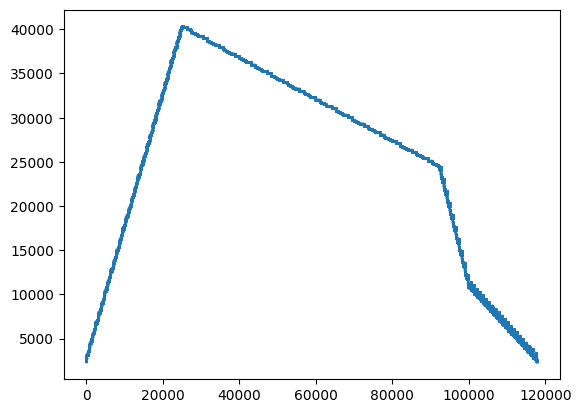

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
# plt.figure(figsize=(100,40))
plt.plot(list(range(len(FlattenEngine()._cuda_mem_trace))), FlattenEngine()._cuda_mem_trace, '.-', markersize=1)

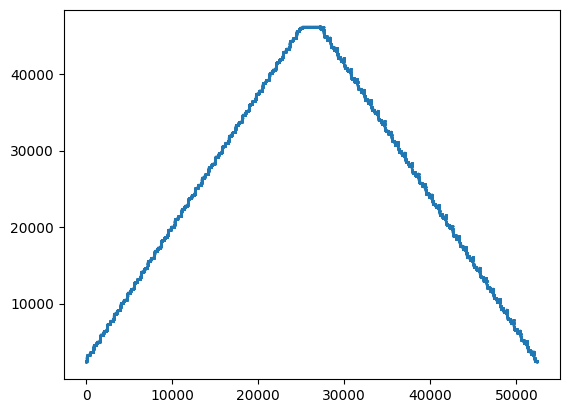

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
# plt.figure(figsize=(100,40))
plt.plot(list(range(len(a))), a, '.-', markersize=1)

In [4]:
for _op in stream_0._flat_seq:
        print([_op], 
              _op._input if isinstance(_op, FlattenOperator) else None,
              _op._output if isinstance(_op, FlattenOperator) else None)
# print(a)
# print(b)
# print(_interval_tot)
# print(FlattenEngine()._interval_tot)

[<operator-1346, init_fn>] None None
[<operator-1347, layernorm_forward>] [Tensor(uid=1218,size=28.0)] [Tensor(uid=1347,size=28)]
[<operator-1348, linear_qkv>] [Tensor(uid=1347,size=28)] [Tensor(uid=1348,size=42)]
[<operator-2439, linear_qkv_branch_offload>] None None
[<operator-1349, matmul_qk>] [Tensor(uid=1348,size=42)] [Tensor(uid=1349,size=128)]
[<operator-1350, softmax_forward>] [Tensor(uid=1349,size=128)] [Tensor(uid=1350,size=128)]
[<operator-1351, dropout_forward>] [Tensor(uid=1350,size=128)] [Tensor(uid=1351,size=128), Tensor(uid=1352,size=64)]
[<operator-2445, dropout_forward_branch_offload>] None None
[<operator-1352, matmul_v>] [Tensor(uid=1351,size=128), Tensor(uid=1348,size=42)] [Tensor(uid=1353,size=14)]
[<operator-2451, matmul_v_branch_offload>] None None
[<operator-1353, linear_forward>] [Tensor(uid=1353,size=14)] [Tensor(uid=1354,size=28)]
[<operator-2457, linear_forward_branch_offload>] None None
[<operator-1354, allreduce_forward>] [Tensor(uid=1354,size=28)] []
[<o